In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib

In [3]:
region_name = 'IGFBP2_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])


        # Access the dataset
        dataset = f['projected_shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df4 = pd.DataFrame(dataset[sequence_number][:])

    df3 = df*df2

    return(df2,df3)
        

In [5]:
model_head = 'counts' #either profile or counts

In [6]:
sequence_number = 0
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])
seq_list = []
folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:

    file_path = 'region_scores/'+celltype+'/'+region_name+"/"+fold+"."+model_head+"_scores.h5"
    dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed

    seq,model_score_fold = get_model_score(file_path,sequence_number)
    seq_list.append(seq)
    if i == 0:
        model_score_sum = model_score_fold
        i+=1
    else:
        model_score_sum = model_score_sum + model_score_fold

model_score_avg = model_score_sum/len(folds)

In [7]:
seq_df = model_score_avg.T
seq_df.columns = ['A','C','G','T']

In [8]:

import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

In [9]:
region_name

'IGFBP2_regions'

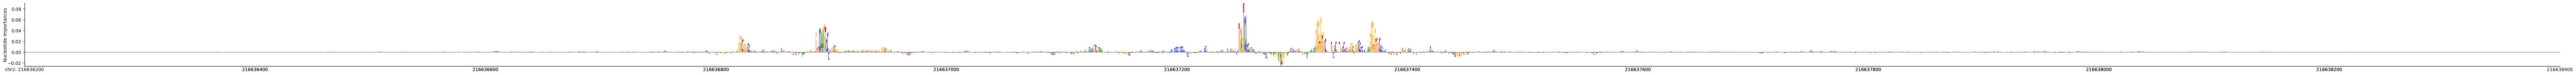

In [10]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [11]:
max_contrib = np.abs(seq_df.T).max()
max_contrib_Z = (max_contrib-max_contrib.mean())/max_contrib.std()

In [12]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>2]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

597


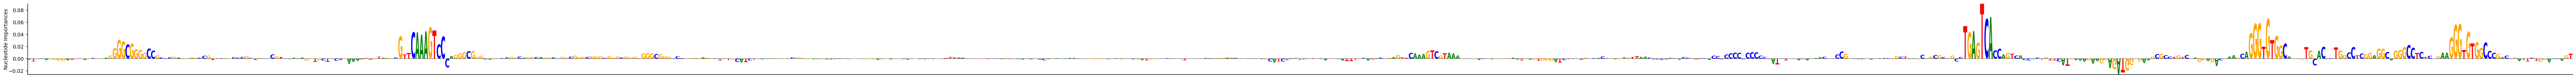

In [13]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+"_trimmed_2.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+"_trimmed_2.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [14]:
#CAAAGTCC: HNF4
#TGAGTCA: JUN + FOS2L
#GGGTGTGGC: KLF3

In [15]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>5]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

526


In [16]:
min_pos,max_pos

(617, 1142)

In [17]:
def plot_region_ISM(seq_df,ISM_df,highlight_SNP=None):

    

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import logomaker
    import numpy as np

    base_colors = {}
    base_colors['A'] = 'g'
    base_colors['C'] = 'b'
    base_colors['G'] = 'gold'
    base_colors['T'] = 'r'

    # Assuming len_seq and celltypes are defined
    len_seq = len(seq_df.index)
    min_pos = np.min(seq_df_trimmed.index)
    max_pos = np.max(seq_df_trimmed.index)
    
    # Create a figure
    fig = plt.figure(figsize=(300/2000*len_seq,5))

    # Create a GridSpec with 1 column and rows equal to the number of cell types
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared y-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in [0,1]]

    ax = axes[0]
    ax.set_title(celltype)    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
#    crp_logo.ax.yaxis.set_ylabel('test')

    ax.set_ylabel("Nucleotide Importances",fontsize=10)

    ax1 = axes[1]
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)
    ax1.set_ylabel("$\Delta$ Log[counts]",fontsize=10)
    
    for base in ['A','G','T','C']:
        df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
    
        x,y = df_base['pos'],df_base['log_counts_diff_avg']
        ax1.scatter(x,y,c=base_colors[base])

    if highlight_SNP:
        snp_pos = highlight_SNP.keys()

        for pos in snp_pos:
            base = highlight_SNP[pos]
            df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
            df_base = df_base.loc[df_base['pos']==pos]
            x,y = df_base['pos'],df_base['log_counts_diff_avg']
            ax1.scatter(x,y,c=base_colors[base],edgecolors='k',linewidths=2)      

    
    ax1.set_xlim([min_pos,max_pos])
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)

    plt.show()
    plt.close()
    

In [18]:
ISM_df = pd.read_csv("IGFBP2_ISM_study_effects_wcounts.tsv",sep="\t",index_col=0)
ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


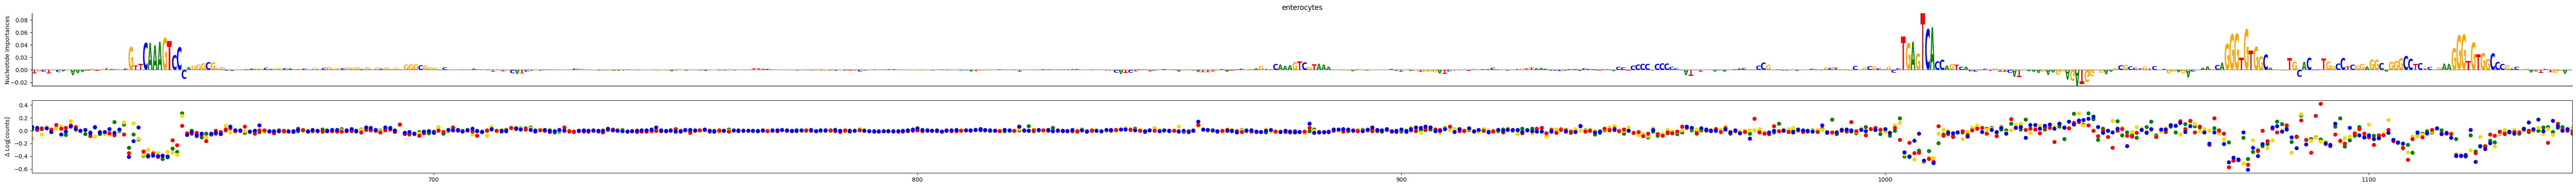

In [20]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed)

In [ ]:
#	ID	chr	pos(hg38)	Human	Chimp
#1	IGFBPi_1	chr2	216638002	G	A
#2	IGFBPi_2	chr2	216636815	G	A
#3	IGFBPi_3	chr2	216636845	T	C
#4	IGFBPi_4	chr2	216636873	C	T
#5	IGFBPi_5	chr2	216636888	G	A

In [25]:
216636888-regions_df['int_start']

0    638.0
Name: int_start, dtype: float64

In [26]:
highlight_SNP = {}
highlight_SNP[1752] = 'A'
highlight_SNP[565] = 'A'
highlight_SNP[595] = 'C'
highlight_SNP[623] = 'T'
highlight_SNP[638] = 'A'

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib

def plot_region_ISM(seq_df, ISM_df, highlight_SNP=None, save_path=None):
    base_colors = {
        'A': 'g',
        'C': 'b',
        'G': 'gold',
        'T': 'r'
    }

    len_seq = len(seq_df)
    min_pos = np.min(seq_df.index)
    max_pos = np.max(seq_df.index)

    # Create a figure
    fig = plt.figure(figsize=(300 / 2000 * len_seq, 5))

    # Create a GridSpec with 2 rows and 1 column
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared x-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    # Plot the sequence logo
    ax = axes[0]
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)

    ax.set_ylabel("Nucleotide Importances", fontsize=10)

    # Plot the ISM data
    ax1 = axes[1]
    ax1.axhline(y=0, color='black', linewidth=1, linestyle='--')

    ax1.set_ylabel("$\Delta$ Log[counts]", fontsize=10)
    
    for base in ['A', 'G', 'T', 'C']:
        df_base = ISM_df[ISM_df['alt'] == base].copy()
        x, y = df_base['pos'], df_base['log_counts_diff_avg']
        ax1.scatter(x, y, c=base_colors[base], label=base)

    if highlight_SNP:
        for pos, base in highlight_SNP.items():
            df_base = ISM_df[(ISM_df['alt'] == base) & (ISM_df['pos'] == pos)]
            x, y = df_base['pos'], df_base['log_counts_diff_avg']
            ax1.scatter(x, y, c=base_colors[base], edgecolors='k', linewidths=2)

    ax1.set_xlim([min_pos, max_pos])

    # Adding legend to the second subplot
    ax1.legend()

    if save_path:
        plt.savefig(save_path,dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()


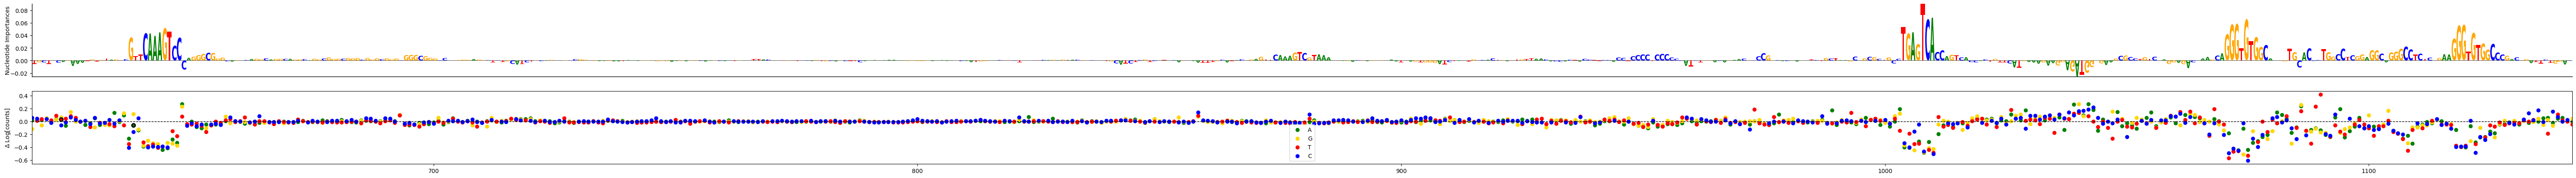

In [28]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_IGFBP2_regions_0_trimmed_5_withISM_"+model_head+".pdf")

In [29]:
min_pos

617

In [30]:
region_name

'IGFBP2_regions'

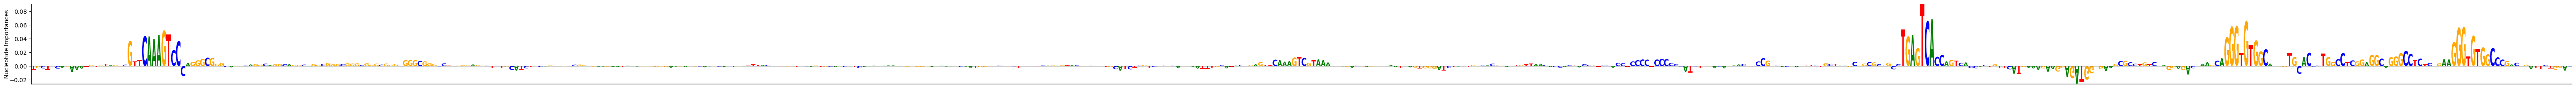

In [31]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5_"+model_head+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5_"+model_head+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [32]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>7]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


517


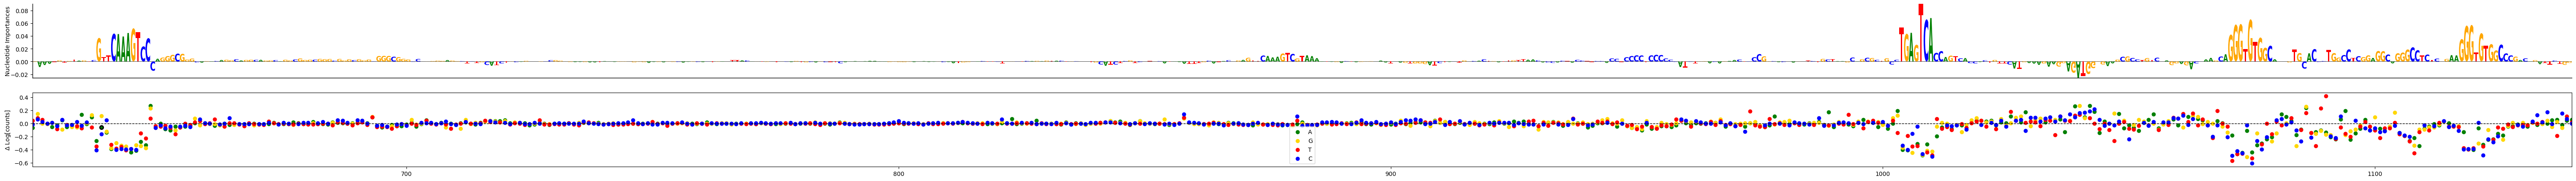

In [33]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_"+region_name+"_regions_0_trimmed_7_withISM_"+model_head+".pdf")